In [7]:
import skrf
import matplotlib.pyplot as plt
#Use the skrf plot style
skrf.stylely()
%matplotlib inline

![Keysight Pathwave TRL Schematic](trl_calkit.png)

In [2]:
calkit = skrf.Network('calkit.s10p', f_unit='GHz')
print('%i-Port Network: \'%s\',  %s' % (calkit.number_of_ports, calkit.name, str(calkit.frequency)))

10-Port Network: 'calkit',  1.0-12.0 GHz, 111 pts


In [20]:
# Load the uncalibrated S-parameters
trl_thru      = calkit.subnetwork([0,1])
trl_open_s1p  = calkit.subnetwork([2])
trl_match_s1p = calkit.subnetwork([3])
trl_line1     = calkit.subnetwork([4,5])
trl_line2     = calkit.subnetwork([6,7])

# Assemble the two reflection measurements into 2 port networks
trl_open   = skrf.two_port_reflect(trl_open_s1p.s11, trl_open_s1p.s11)
trl_match  = skrf.two_port_reflect(trl_match_s1p.s11, trl_match_s1p.s11)

trl_thru.name = 'thru'
trl_open.name = 'open'
trl_match.name = 'match'
trl_line1.name = '12.34 mm line'
trl_line2.name = '4.79 mm line'

# Load the Beatty DUT
# https://www.signalintegrityjournal.com/articles/194-resonant-test-structures-primer-and-signal-integrity-applications
trl_beatty = calkit.subnetwork([8,9])

C:\Users\derek\Miniconda3\envs\phd\lib\site-packages\skrf\mathFunctions.py:265: RuntimeWarning: divide by zero encountered in log10
  out = 20 * npy.log10(z)
C:\Users\derek\Miniconda3\envs\phd\lib\site-packages\skrf\mathFunctions.py:265: RuntimeWarning: divide by zero encountered in log10
  out = 20 * npy.log10(z)


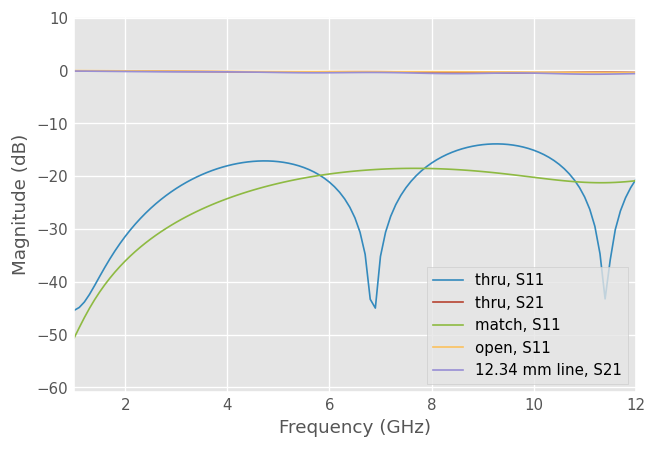

In [24]:
# Print a few representative plots
trl_thru.plot_s_db(0,0)
trl_thru.plot_s_db(1,0)
trl_match.plot_s_db(0,0)
trl_open.plot_s_db(0,0)
trl_line1.plot_s_db(1,0)

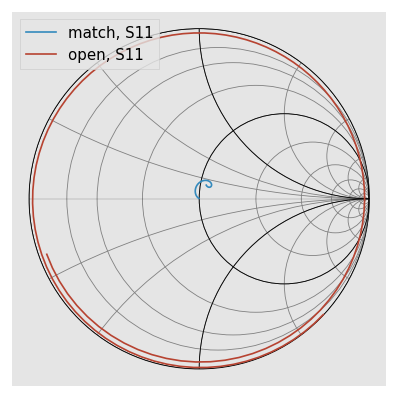

In [25]:
trl_match.plot_s_smith(0,0)
trl_open.plot_s_smith(0,0)

In [26]:
# Simulation is ideal so no switch terms are supplied
#sw_terms = skrf.Network('sw_terms.s2p')
#switch_terms = (sw_terms.s11, sw_terms.s22)

# Measurement with load on both ports for isolation calibration
#ll = skrf.Network('load_load.s2p')

cal_trl = skrf.TRL(
        measured = [trl_thru, trl_open, trl_line1],
#        Grefls = [1], #Estimate of the reflection coefficient
#        er_est = 3.9, #Estimated effective permittivity
        l = [0, 12.34e-3], #Line lengths
#        gamma_root_choice = 'real', #Assumes that lines are lossy
#        switch_terms = switch_terms,
#        isolation = ll
        )

C:\Users\derek\Miniconda3\envs\phd\lib\site-packages\skrf\calibration\calibration.py:2001: UserWarning: No switch terms provided
  warn('No switch terms provided')


C:\Users\derek\Miniconda3\envs\phd\lib\site-packages\skrf\mathFunctions.py:265: RuntimeWarning: divide by zero encountered in log10
  out = 20 * npy.log10(z)
C:\Users\derek\Miniconda3\envs\phd\lib\site-packages\skrf\mathFunctions.py:265: RuntimeWarning: divide by zero encountered in log10
  out = 20 * npy.log10(z)


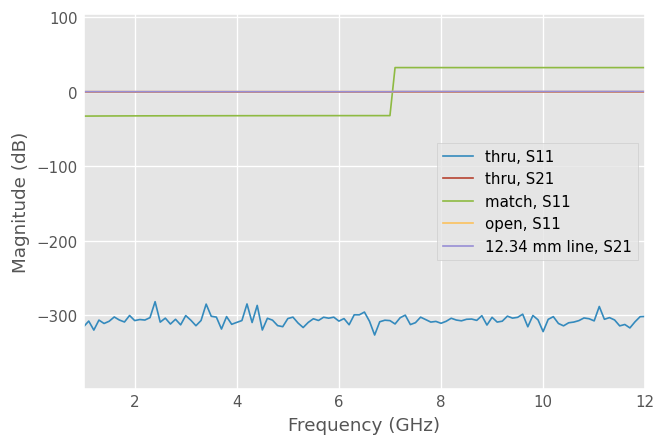

In [28]:
# Print a few representative plots
cal_trl.apply_cal(trl_thru).plot_s_db(0,0)
cal_trl.apply_cal(trl_thru).plot_s_db(1,0)
cal_trl.apply_cal(trl_match).plot_s_db(0,0)
cal_trl.apply_cal(trl_open).plot_s_db(0,0)
cal_trl.apply_cal(trl_line1).plot_s_db(1,0)

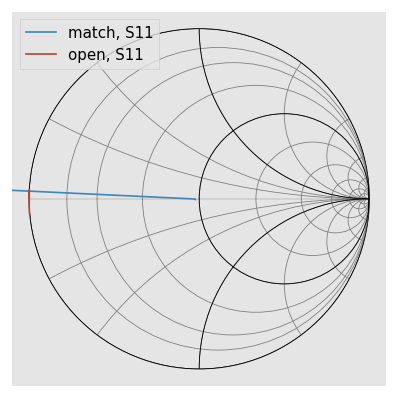

In [29]:
cal_trl.apply_cal(trl_match).plot_s_smith(0,0)
cal_trl.apply_cal(trl_open).plot_s_smith(0,0)